## Méthodes d'optimisation stochastique

## I. Minimisation stochastique d'une fonction déterministe


On s'intéresse au problème $\min f(x) =\max_{i=1\dots m}|a_i^Tx-b_i | = \max_{i=1\dots m} |(Ax-b)_i|.$ 

On suppose que $a_i$ est un vecteur colonne représentant la $i$ eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne nulle et d'écart type identité.

**Question 1 :** Constuire $A$ et $b$. Proposer le calcul d'un sous-gradient en $x$ de $f$. On pourra utiliser la fonction findmax de Julia. 


$$\partial f(x) = sgn(f(x)) \times a_i$$
Avec $i$ tel que $$f(x) = |(Ax-b)_i|$$

In [88]:
# Construction des données A  et b
# Insérer votre code
m, n = 100, 20
# Génération de la matrice A de taille mxn à partir de distributions gaussiennes de moyenne 0 et d' écart-type 1
A = randn(m, n)
# Génération du vecteur b de taille m à partir de distributions gaussiennes de moyenne 0 et d' écart-type 1
b = randn(m, 1)
x = zeros(n, 1)
# Fin insérer code

# Fonction calculant la valeur de f en x
function fval(A,b,x)
    return maximum(abs.(A*x - b))
end

# Fonction calculant un sous-gradient en x de f
function subgrad(A,b,x) 
    # Insérer votre code
    # Calculer le sous-gradient de f en x
    fx = A*x - b
    (~,ind) = findmax(fx)
    i = ind[1]
    subgrad = sign(fx[i]) .* (A[i,:])
    return subgrad
    # Fin insérer code
end

subgrad (generic function with 1 method)

**Question 2 :** Ce problème peut se reformuler comme un problème de programmation linéaire : $$(\mathcal{P}_{lp})\quad \left\{ \begin{array}{c} \min_{(x,R)\in \mathbb{R}^n\times \mathbb{R}} h(x,R)=R\\
s.c. \quad-R*e\leq A*x-b\leq R*e\end{array}\right.$$ avec $e=[1,\cdots,1]^T\in \mathbb{R}^m$. Résoudre le problème $(\mathcal{P}_{lp})$ en utilisant le solveur "GLPK" de la librairie JuMP. Plus d'informations sont disponibles ici :  http://www.juliaopt.org/JuMP.jl/latest/quickstart/

In [89]:
#using Pkg
#Pkg.add("JuMP"); 
#Pkg.add("GLPK")
using JuMP
using GLPK

# Définition du modèle
# Insérer votre code
model = Model(GLPK.Optimizer)
# Fin insérer code

# Définition des variables d'optimisation
# Insérer votre code
@variable(model, x[1:n])
@variable(model, R)
# Fin insérer code

# Définition de la fonctionnelle à minimiser
#Insérer votre code
@objective(model, Min, R)
# Fin insérer code

# Définition des contraintes
# Insérer votre code
@constraint(model, c1[i=1:m], -R <= sum(A[i,j]*x[j] for j in 1:n) - b[i])
@constraint(model, c2[i=1:m], R >= sum(A[i,j]*x[j] for j in 1:n) - b[i])
# Fin insérer code
        
# Résolution        
# Insérer votre code
optimize!(model)
# Fin insérer code
        
# Résultats à optimalité                
# Insérer votre code
println(solution_summary(model))
xstar = value.(x)
Rstar = value(R)

# Fin insérer code
println("The function value at the solution is: ",Rstar, " or ",findmax(abs.(A*xstar-b)))


* Solver : GLPK

* Status
  Termination status : OPTIMAL
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Message from the solver:
  "Solution is optimal"

* Candidate solution
  Objective value      : 1.4358683328467725
  Objective bound      : -Inf
  Dual objective value : 1.4358683328467707

* Work counters
  Solve time (sec)   : 0.00279

The function value at the solution is: 1.4358683328467725 or (1.435868332846777, CartesianIndex(80, 1))


**Question 3 :** Résoudre le problème en utilisant un algorithme de sous-gradient. Dans un premier temps vous utiliserez un sous-gradient exact (Question 1), puis vous introduirez un bruit artificiel qui suit une distribution normale de moyenne nulle et d'écart-type $3 e-1$.

**Question 4 :** Vous afficherez les courbes de convergence de $f_{best}^k-f_{star}$, avec $f_{star}$ obtenue à la Question 1. Donnez la valeur minimale de $f_{best}^k-f_{star}$.

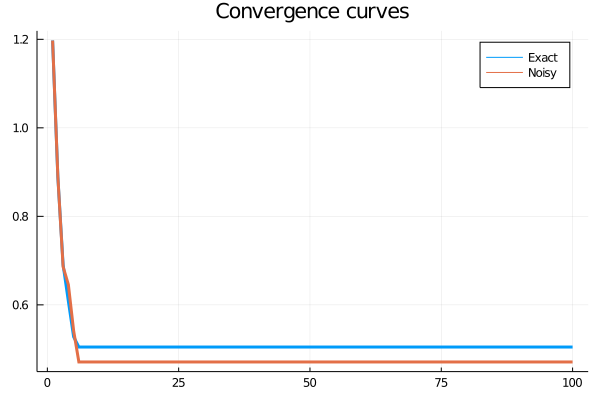

In [141]:
#Pkg.add("Plots")
using Plots

#Initialisation
x = zeros(n,1);
i = 0;
fbest =1e10; # $f_{best}^0$: cas du sous-gradient exact
fbestp=1e10; # $f_{best}^0$: cas du sous-gradient bruité
histo =[];# Suite des itérés f_{best}^k-f_{star} pour le cas du sous-gradient exact
histop=[];# Suite des itérés f_{best}^k-f_{star}, pour le cas du sous-gradient bruité

#Niveau de bruit
noise_lvl=.3;

# Resolution 
# Insérer votre code
# Boucle sur les itérations
iterMax = 100
xk = x
xpk = x
for i in 1:iterMax

    # Mise à jour de fbest
    global fbest = min(fbest,fval(A,b,xk))
    global fbestp = min(fbestp,fval(A,b,xpk))

    # Calcul du sous-gradient exact
    g = subgrad(A,b,xk)

    # Calcul du sous-gradient bruité
    gp = g + noise_lvl*randn(n,1)

    # Calcul du pas
    alpha = 1e-2
    alphap = 1e-2

    # Mise à jour de x
    global xk = xk - alpha*g
    global xpk = xpk - alphap*gp


    # Mise à jour des historiques
    push!(histo,fbest-Rstar)
    push!(histop,fbestp-Rstar)
end
# Fin insérer code

#Affichage des courbes de convergence
iter=1:iterMax;
hf=[histo,histop];
plot(iter,hf,title="Convergence curves",label=["Exact" "Noisy"],lw=3)

## II. Minimisation stochastique d'une fonction stochatique



On s'intéresse au problème
$$\min_x f(x) =\text{E} (\max_{i=1\dots m}|a_i^Tx-b_i |).$$

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne connue $\bar{A}$ et $\bar{b}$ (non nécesairement nulle) et d'écart type identité.

**Question 5 :** Proposer deux fonctions d'évaluation de la fonction $f$ et d'un sous-gradient de $f$ basées sur des échantillons de taille $M$.


In [142]:
# Evaluation de f
function fvals(Abar,bbar,noise,xs,M) 
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon

# Insérer votre code
sum = 0
for i in 1:M
    sum += fval(Abar + noise*randn(m,n),bbar + noise*randn(m,1),xs)
end

return sum/M
# Fin insérer code

end

# Evaluation d'un sous-gradient
function subgrads(Abar,bbar,noise,xs,M)
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon
    
# Insérer votre code
sum = zeros(n,1)
for i in 1:M
    sum += subgrad(Abar + noise*randn(m,n),bbar + noise*randn(m,1),xs)
end

return sum/M
# Fin insérer code

end


subgrads (generic function with 1 method)

**Question 6 :** Comparer les courbes de convergence du problème déterministe $$ \min_x f(x) = \max_{i=1\dots m}|\text{E} (a_i)^Tx-\text{E} (b_i) |,$$ et du problème stochastique obtenu avec $M=10,100,1000$ échantillons. Donnez la valeur minimale de $f$.

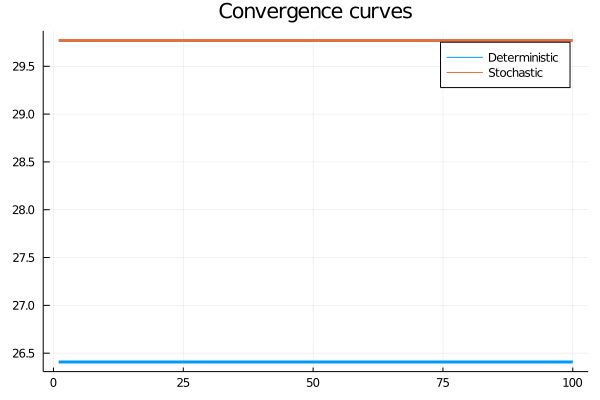

In [143]:
# Données
Abar=10*ones(m,n)+1*randn(m,n);
bbar=10*randn(m,1);

#x_0
xd = zeros(n,1); # problème déterministe
xs = xd; # problème stochastique

# Bruit et echantillon
M  = 200;
noise  = 4;

j = 0;

fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
histod =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution déterministe
histos =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution stochastique

# Insérer votre code
iterMax = 100
for i in 1:iterMax

    # Mise à jour de fbest
    global fbestd = min(fbestd,fval(Abar,bbar,xd))
    global fbests = min(fbests,fvals(Abar,bbar,noise,xs,M))

    # Calcul du sous-gradient exact
    gd = subgrad(Abar,bbar,xd)

    # Calcul du sous-gradient bruité
    gs = subgrads(Abar,bbar,noise,xs,M)

    # Calcul du pas
    alphad = 1e-2
    alphas = 1e-2

    # Mise à jour de x
    global xd = xd - alphad*gd
    global xs = xs - alphas*gs

    # Mise à jour des historiques
    push!(histod,fbestd-Rstar)
    push!(histos,fbests-Rstar)
end
# Fin insérer code
#Affichage

iter=1:100;
hf=[histod,histos];
plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)

**Question 7 :** Répéter les expériences et comparer les valeurs meilleurs valeurs de f obtenues ($f_{best}$) aprs un nombre fixé d'itérations. Donnez la valeur minimale de $f_{best}$

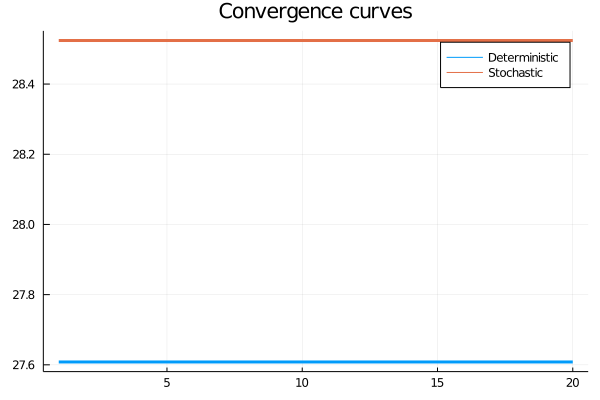

In [144]:
# Données
Abar=10*ones(m,n)+1*randn(m,n);
bbar=10*randn(m,1);

# x_0
xd = zeros(n,1); # résolution déterministe
xs = xd;  # résolution stochastique

# Bruit et echantillon
M  = 200;
noise  = 4;

#Nombre d'itérations
niter=100;

j = 0;

fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
fbesttd=[]; # f_{best} pour chaque expériences dans le cas d'une résolution déterministe
fbestts=[]; # f_{best} pour chaque expériences dans le cas d'une résolution stochastique

for nexp=1:20
    # Répétition des expériences    
# Insérer votre code
    for i in 1:niter

        # Mise à jour de fbest
        global fbestd = min(fbestd,fval(Abar,bbar,xd))
        global fbests = min(fbests,fvals(Abar,bbar,noise,xs,M))

        # Calcul du sous-gradient exact
        gd = subgrad(Abar,bbar,xd)

        # Calcul du sous-gradient bruité
        gs = subgrads(Abar,bbar,noise,xs,M)

        # Calcul du pas
        alphad = 1e-2
        alphas = 1e-2

        # Mise à jour de x
        global xd = xd - alphad*gd
        global xs = xs - alphas*gs
    end
    push!(fbesttd,fbestd)
    push!(fbestts,fbests)
# Fin insérer code
end

#Affichage

iter=1:20;
hf=[fbesttd,fbestts];
plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)